In [1]:
%load_ext autoreload
%autoreload 2

from copy import deepcopy
import os
import time
import pydrake
from pydrake.all import (
    CommonSolverOption,
    MathematicalProgram,
    MakeSolver,
    GurobiSolver,
    Solve,
    SolverOptions,
    VPolytope
)
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

from geometric_only_grammar import *

Minimal grammar definition: each node has:
- a pose x
- a type name

A node class defines:
- its child type (by name or None)
- max # of children
- the geometric stop prob p (1. = always 1 child, 0. = infinite children)
- the region in which children will be produced (uniformly at random), in the frame of the node, in the form of an axis-aligned bounding box

E.g. object groups in plane:
- Root node produces object clusters and uniform random locations inside [0, 1]^2.
- Each cluster produces up points uniformly in a 0.1-length box centered at the cluster center.

Text(0.5, 1.0, 'Observed nodes')

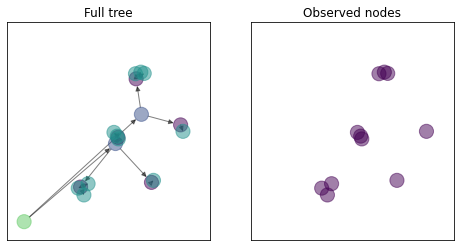

In [2]:
# Grammar implementing clusters of points in 2D.
cluster_grammar = {
    "point": NodeDefinition(child_type=None, p=None, max_children=None, bounds=None),
    "cluster_cluster": NodeDefinition(child_type="cluster", p=0.5, max_children=3, bounds=[-np.ones(2)*0.25, np.ones(2)*0.25]),
    "cluster": NodeDefinition(child_type="point", p=0.25, max_children=3, bounds=[-np.ones(2)*0.05, np.ones(2)*0.05]),
    "root": NodeDefinition(child_type="cluster_cluster", p=0.5, max_children=2, bounds=[np.ones(2)*0.05, np.ones(2)*0.95])
}
cluster_grammar_observed_types = ["point"]

np.random.seed(0)
example_tree = sample_tree(cluster_grammar)
observed_nodes = deepcopy(get_observed_nodes(example_tree, cluster_grammar_observed_types))

plt.figure().set_size_inches(8, 4)
plt.subplot(1, 2, 1)
draw_tree(example_tree)
plt.title("Full tree")
plt.subplot(1, 2, 2)
draw_observed_nodes(observed_nodes)
plt.title("Observed nodes")

We want to do probabilistic scene parsing: given an observed scene $o$ + a grammar description, *sample trees $T$ from the posterior* $p(T | o)$.

The SMC idea (in this context) is to build up $ p(T | o) $ by building up to it one choice at a time, where each choice is conditioned on previously made choices. Define $z_{1:N}$ as the sequence of all random choices made to create $T$. Omitting conditioning on $o$ for clarity: $p(z_{1:N}) = p(z_{1:N} | z_{1:N-1})  p(z_{1:N-1})$, which can be continued recursively. (See Ritchie's "Controlling Procedural Modeling Programs with Stochastically-Ordered Sequential Monte Carlo" for a closely related example applying this to constructive procedural models of scenes.)

In practice, this means: we have a population of particles that each represent a partially-generated scene tree. Each particle takes a single "step" -- we'll consider the expansion of a single node to be a step here. Then the population of particles is evaluated w.r.t. their partial tree probabilities and how likely they are to construct the desired output; unlikely particles are pruned and replaced with duplicates of existing particles; and the population advances again until all particles are terminated.

Critically, this is only better than blindly rolling out the proposed tree a bunch of times in parallel if the intermediate trees can be meaningfully compared to the desired output to tell if they're closer or farther to it.